In [10]:
import sys
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt

# Configuration des chemins
ROOT_DIR = Path("..").resolve()
sys.path.append(str(ROOT_DIR))

# Autoreload
%load_ext autoreload
%autoreload 2

from src.asr_inference import ASRPredictor
from src.evaluation import ASREvaluator

print(f"Racine du projet : {ROOT_DIR}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Racine du projet : C:\Users\benic\Documents\Projet_DL_Translation


In [6]:
# On charge le modèle "small" (environ 500Mo de RAM, assez rapide)
# Tu pourras tester "base" (plus rapide) ou "medium" (plus précis mais lent)
predictor = ASRPredictor(root_dir=ROOT_DIR, model_size="medium")

--- Initialisation ASR ---
Device detecte : CPU
Chargement du modele Whisper (medium). Cela peut prendre un instant...


100%|█████████████████████████████████████| 1.42G/1.42G [02:17<00:00, 11.1MiB/s]


✅ Modele charge et pret !


In [7]:
print("=== ÉTAPE 1 : Test sur une vidéo complète (Génération SRT) ===")

# On récupère le premier ID de vidéo du split VALID
valid_csv = ROOT_DIR / "data" / "processed" / "valid_asr_fr.csv"
df_valid = pd.read_csv(valid_csv)
first_video_id = df_valid['video_id'].iloc[0]

archive_name = "mtedx_fr.tgz"
srt_output_dir = ROOT_DIR / "data" / "processed" / "subtitles"
srt_output_dir.mkdir(parents=True, exist_ok=True)

try:
    # 1. On extrait le FLAC complet temporairement
    flac_path = predictor.extract_single_flac(archive_name, first_video_id)
    
    # 2. On lance Whisper sur la vidéo entière pour créer le SRT
    srt_path = srt_output_dir / f"{first_video_id}.srt"
    predictor.transcribe_full_video_to_srt(flac_path, srt_path, language="fr")
    
    # 3. Nettoyage
    os.remove(flac_path)
    
    # Aperçu des premières lignes du SRT généré !
    print("\n--- Aperçu du fichier SRT généré ---")
    with open(srt_path, "r", encoding="utf-8") as f:
        print("".join([next(f) for _ in range(20)])) # Affiche les 10 premières lignes
        
except Exception as e:
    print(f"Erreur : {e}")

=== ÉTAPE 1 : Test sur une vidéo complète (Génération SRT) ===
Extraction temporaire de 9fxo9YJhnG8.flac...
Transcription de la video complete : 9fxo9YJhnG8.flac


c:\Users\benic\Documents\Projet_DL_Translation\venv_dl\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Fichier SRT genere avec succes : C:\Users\benic\Documents\Projet_DL_Translation\data\processed\subtitles\9fxo9YJhnG8.srt

--- Aperçu du fichier SRT généré ---
1
00:00:00,000 --> 00:00:00,660
Derniers

2
00:00:00,660 --> 00:00:02,000
gossip

3
00:00:04,480 --> 00:00:05,900
Janxième

4
00:00:06,100 --> 00:00:07,580
Vers егоungen

5
00:00:07,600 --> 00:00:09,620
Volumee




In [9]:
print("=== ÉTAPE 2 : Inférence sur les segments (Pour évaluation) ===")

# On va transcrire un échantillon de 20 segments pour valider le concept (et ne pas attendre 3 heures)
# Mets limit=None quand tu voudras faire tout le dataset valid
LIMIT_TEST = None 

df_results = predictor.transcribe_segments_to_csv(
    csv_path=valid_csv,
    split="valid",
    limit=LIMIT_TEST
)

# On affiche la grande table demandée pour le comparatif visuel
print("\n--- Comparatif Visuel (Cible vs Prédit) ---")
display_cols = ['segment_id', 'start_time', 'end_time', 'text_fr', 'text_pred']

# Configuration Pandas pour bien voir le texte sans qu'il soit coupé
pd.set_option('display.max_colwidth', None)
display(df_results[display_cols].head(10))
pd.reset_option('display.max_colwidth')

=== ÉTAPE 2 : Inférence sur les segments (Pour évaluation) ===
--- Transcription des segments (VALID) ---


Inference ASR: 100%|██████████| 1036/1036 [4:32:37<00:00, 15.79s/it]  

✅ Resultats sauvegardes dans : C:\Users\benic\Documents\Projet_DL_Translation\data\processed\valid_asr_results.csv

--- Comparatif Visuel (Cible vs Prédit) ---


,segment_id,start_time,end_time,text_fr,text_pred
0,9fxo9YJhnG8_0000,14.26,15.21,J'ai eu le coup de foudre.,J'ai eu le coup de foudre.
1,9fxo9YJhnG8_0001,15.69,21.25,"C'était il y a 10 ans, je me promenais dans la fac, mes cahiers sous le bras, telle une jeune étudiante passionnée.","C'était il y a 10 ans, je me promenais dans les couloirs de ma fac, mes cahiers sous le bras, tel une jeune étudiante passionnée."
2,9fxo9YJhnG8_0002,22.44,23.82,"Dans ses pensées, il m'a bousculée.","C'est pas ça, il m'a bousculé."
3,9fxo9YJhnG8_0003,23.84,25.17,"Ça m'a énervée, je me suis retournée.","Je m'a énervée, je me suis retournée."
4,9fxo9YJhnG8_0004,25.85,26.36,Je l'ai regardé.,oui相사� candy
5,9fxo9YJhnG8_0005,26.84,31.74,Il m'a regardée avec ses grands yeux bleus et on s'est aimés au premier regard.,m'a regardé avec ses grands yeux bleus et on s'est aimé au premier regard.
6,9fxo9YJhnG8_0006,32.89,39.07,"Aujourd'hui encore, quand je me lève le matin, je regarde mon homme à côté de moi et je suis toujours émerveillée.","Aujourd'hui encore, quand je me lève le matin, je regarde mon homme à côté de moi et je suis toujours émerveillée."
7,9fxo9YJhnG8_0007,39.43,44.11,"J'ai mon cœur qui palpite et encore les papillons dans le ventre, presque 24 heures sur 24.","J'ai mon coeur qui palpite, j'ai encore les papillons dans le ventre, presque 24 heures sur 24."
8,9fxo9YJhnG8_0008,44.52,45.54,Rien n'a changé.,rien n'a changé.
9,9fxo9YJhnG8_0009,46.39,49.10,Rien n'a changé : je l'aime comme au premier jour.,"Rien n'a changé, je l'aime comme au premier jour."


In [11]:
csv_results_path = ROOT_DIR / "data" / "processed" / "valid_asr_results.csv"

# Initialisation de notre Juge
evaluator = ASREvaluator(csv_path=csv_results_path)

print("=== 1. PERFORMANCES GLOBALES (ASR) ===")
wer, cer = evaluator.compute_global_metrics()

print(f"Word Error Rate (WER)      : {wer * 100:.2f} %")
print(f"Character Error Rate (CER) : {cer * 100:.2f} %")

print("\n(Note : Un WER < 15% est considéré comme bon, < 10% comme excellent)")

=== 1. PERFORMANCES GLOBALES (ASR) ===
Normalisation du texte en cours...
Word Error Rate (WER)      : 8.10 %
Character Error Rate (CER) : 4.42 %

(Note : Un WER < 15% est considéré comme bon, < 10% comme excellent)


In [13]:
print("=== 2. ANALYSE DES PIRES ERREURS ===")
print("Qu'est-ce qui fait trébucher le modèle ?\n")

worst_df = evaluator.get_worst_segments(top_n=10)

pd.set_option('display.max_colwidth', None)
display_cols = ['wer', 'text_fr', 'text_pred']

# On met le WER en pourcentage pour l'affichage
worst_display = worst_df[display_cols].copy()
worst_display['wer'] = worst_display['wer'].apply(lambda x: f"{x*100:.0f}%")

display(worst_display)
pd.reset_option('display.max_colwidth')

=== 2. ANALYSE DES PIRES ERREURS ===
Qu'est-ce qui fait trébucher le modèle ?



,wer,text_fr,text_pred
837,300%,Lalala lalala.,La la la la la la...
939,200%,(Musique) (Applaudissements) (Ovation),"Achever plus graveque un style, des ..."
820,150%,"Papa, papa !",ba ba ba
842,125%,"Non mais, tu t'entends ?",Non ? T'es comme tout le monde !
851,100%,"Sans toi, c'est impossible.",C'est un peu...
817,100%,"Oui, je fais bien le métro.",t'as palmit trop.
823,100%,Voix : Tu divagues encore.,C'est divagant.
618,100%,"Alors vous, quelle barrière voulez-vous briser ?","Alors vous, c'est quoi la barrière que vous voulez briser ?"
609,100%,"Pas très intelligent, le gars.",pour continuer ce programme.
572,100%,"Eh bien moi, je n'ai pas 40 000 euros.","Ben moi je ne sais pas, je ne sais pas à 40 000 euros."


=== 3. ANALYSE CATÉGORIELLE (Noms Propres, Chiffres, Bruit) ===


,Categorie,Nb Segments,WER
0,Didascalies & Bruits (Ex: Applaudissements),39,0.273349
1,Segments avec Chiffres,75,0.119014
2,Segments avec Noms Propres (Majuscules),115,0.076224
3,Standard (Aucun des trois),820,0.072075


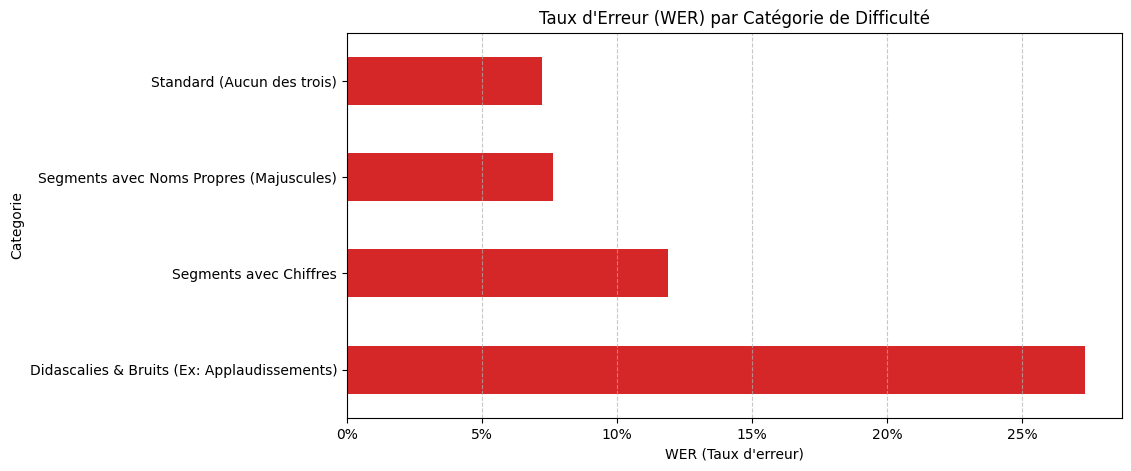

In [14]:
print("=== 3. ANALYSE CATÉGORIELLE (Noms Propres, Chiffres, Bruit) ===")

df_categories = evaluator.analyze_error_categories()
display(df_categories)

# Visualisation Graphique
if not df_categories.empty:
    df_plot = df_categories.set_index('Categorie')
    ax = df_plot['WER'].plot(kind='barh', color='#d62728', figsize=(10, 5))
    plt.title("Taux d'Erreur (WER) par Catégorie de Difficulté")
    plt.xlabel("WER (Taux d'erreur)")
    
    # Formater l'axe X en pourcentage
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [16]:
print("=== 4. EXEMPLES CLASSIQUES : LES CHIFFRES ===")
# On va chercher un segment avec un chiffre où le modèle s'est trompé
mask_numbers = evaluator.df['text_fr'].str.contains(r'\d', regex=True)
mask_errors = evaluator.df['wer'] > 0

df_num_errors = evaluator.df[mask_numbers & mask_errors]

if not df_num_errors.empty:
    display_cols = ['text_fr', 'text_pred', 'wer']
    pd.set_option('display.max_colwidth', None)
    display(df_num_errors.sample(min(5, len(df_num_errors)))[display_cols])
    pd.reset_option('display.max_colwidth')
else:
    print("Bravo, le modèle a traduit tous les chiffres parfaitement !")

=== 4. EXEMPLES CLASSIQUES : LES CHIFFRES ===


,text_fr,text_pred,wer
413,Le Soleil se situe à 150 millions de km de nous.,Le soleil se situe à 150 millions de kilomètres de nous.,0.090909
353,Cela nous permet de mesurer que notre galaxie se déplace à une vitesse faramineuse de 630 kilomètres par seconde.,Cela nous permet de mesurer que notre galaxie se déplace à une vitesse farabineuse de 630 km par seconde.,0.105263
639,Donc je décide de partir faire une retraite de 3 jours.,Donc je décide de partir faire une retraite de trois jours.,0.090909
390,"Ces 8 000 galaxies sont réparties sur une cartographie qui a doublé de taille par rapport à celle de la fin des années 90, des Sept Samouraïs.",Ces 8000 galaxies sont réparties sur une cartographie qui a doublé de taille par rapport à celle de la fin des années 90 des sept savons-railles.,0.111111
7,"J'ai mon cœur qui palpite et encore les papillons dans le ventre, presque 24 heures sur 24.","J'ai mon coeur qui palpite, j'ai encore les papillons dans le ventre, presque 24 heures sur 24.",0.117647
